In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
pip install -q seaborn

In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0


In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")      #데이터셋 다운
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,  #받아진 데이터(파이썬에서 데이터를 다룰려면 판다스 사용)
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()    #tail() = 맨 마지막칸 5개 정도 데이터 읽기 [{head()=맨 앞부분 5개} 랑 비슷]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
len(dataset) #데이터 사이즈 함수

398

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna() #dropna() api호출 -> 쓸모없는 데이터 제거

In [10]:
len(dataset) #데이터 사이즈 함수

392

In [11]:
dataset.pop('Origin') #모델 데이터 제거

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

In [12]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70
...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82


In [13]:
train_dataset = dataset.sample(frac=0.8,random_state=0)   #트레이닝, 테스트 셋 나누기
test_dataset = dataset.drop(train_dataset.index)

In [14]:
len(train_dataset), len(test_dataset)

(314, 78)

In [15]:
train_stats = train_dataset.describe()  #describe()함수 : 평균값과 표준편차를 구할 수 있음
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [16]:
train_labels = train_dataset.pop('MPG') #정규화에서 빼기
test_labels = test_dataset.pop('MPG')

In [17]:
def norm(x):         #데이터 정규화
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
normed_train_data.head() #정규분포를 따르게 정규화가 됨

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


In [19]:
train_dataset.shape  #모델 만들기

(314, 6)

In [20]:
normed_train_data.shape  #(314줄[가변적], 6개 칼럼[중요])

(314, 6)

In [21]:
inputs = keras.Input(shape=(normed_train_data.shape[1],))   
h = layers.Dense(64)(inputs)  #행렬 만들기           h = layers.Dense(64, activation='relu')(inputs)  ==  h = layers.Activation('relu')(h)
h = layers.Activation('relu')(h)   #룰루로 만들어보기
h = layers.Dense(32)(h)  #행렬 추가
outputs = layers.Dense(1)(h)

In [22]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model.compile(loss='mse',          
              optimizer=tf.keras.optimizers.RMSprop(0.001))
#y = w*x + b
#optimizer = 오차 줄이기 위해 값 변경 정하는 함수

In [24]:
model.summary()  #모델 시각화(모델 확인)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


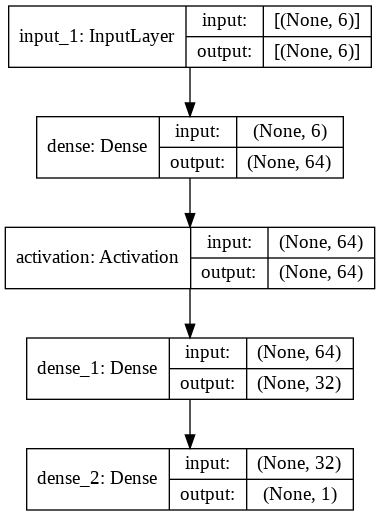

In [25]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True) #레이어의 인풋 아웃풋 표현

In [26]:
normed_train_data[:5] #특정한 것만 가져오기

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


In [27]:
normed_train_data[:5].shape

(5, 6)

In [28]:
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)   #predict함수 = 예측 하기
example_result

array([[-0.0506994 ],
       [ 0.19136351],
       [-0.1038996 ],
       [ 0.03758347],
       [ 0.1820426 ]], dtype=float32)

In [29]:
EPOCHS = 100  #학습을 몇번 반복할지 정하기 [무조건 필요]

#fit함수 = 학습시키기
history = model.fit(      
  normed_train_data, train_labels,       #인풋 데이터(x), 아웃풋 데이터(y) [무조건 있어야 됨]
  epochs=EPOCHS, validation_split = 0.2)   #validation_split = 과적합을 막기 위한 데이터

Epoch 1/100
8/8 [==============================] - 1s 26ms/step - loss: 560.8195 - val_loss: 546.6509
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 505.4665 - val_loss: 492.1084
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 453.5946 - val_loss: 434.9762
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 399.0470 - val_loss: 376.1272
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 343.2736 - val_loss: 316.3932
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 286.0998 - val_loss: 257.1772
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 231.0854 - val_loss: 201.0269
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 179.6300 - val_loss: 150.3962
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 133.7143 - val_loss: 106.8978
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 95.6507 - val_loss

In [30]:
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) #val_loss 10번 연속 줄어들지 않으면 학습 멈춤

model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, callbacks=[early_stop])

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 6.7031 - val_loss: 8.7874
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 6.7585 - val_loss: 8.8736
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 7.0533 - val_loss: 8.6822
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 6.8225 - val_loss: 8.9427
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 6.7512 - val_loss: 9.0127
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 7.1142 - val_loss: 8.7586
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 6.7778 - val_loss: 9.0078
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 7.0147 - val_loss: 8.8811
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 6.8329 - val_loss: 8.9262
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 6.7062 - val_loss: 8.8896
Epoch 11/100
8/8 [==========

In [32]:
loss = model.evaluate(normed_test_data, test_labels, verbose=2) #evaluate함수 = 평가(오차 구하기)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(loss))

3/3 - 0s - loss: 6.9100
테스트 세트의 평균 절대 오차:  6.91 MPG


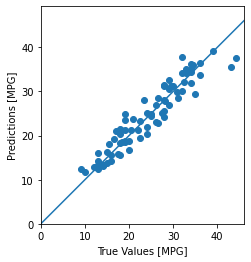

In [33]:
test_predictions = model.predict(normed_test_data).flatten() #예측

plt.scatter(test_labels, test_predictions) #그래프로 그리기 
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

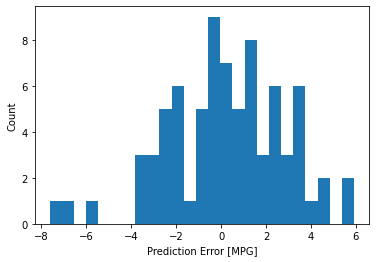

In [34]:
error = test_predictions - test_labels #오차분포를 시각적으로 표현
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")